In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [2]:
#GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avasilable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Avasilable:  1


2022-06-01 15:34:10.793267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:34:10.811342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:34:10.811466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Massive data augmentation

### Auxiliar Functions

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])


def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_batch(image_batch, label_batch, epoch):
  columns = 5
  rows = BATCH_SIZE / columns + 1  
  epochImages = plt.figure(figsize=(15, 3 * rows))
  epochImages.suptitle('epoch {}'.format(epoch))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batchSimple(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [4]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [30]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

In [6]:
pathTrain = 'GTSRB_TP/train_images'
#pathTrainBalance = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'

In [7]:
BATCH_SIZE = 64
HEIGHT = 32
WIDTH = 32
#Classes names
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


### Prepare dataset

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

2022-06-01 15:34:11.056479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 15:34:11.056980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:34:11.057115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:34:11.057176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)
#print(dataset)
# note: this only works if dataset is not repeating
train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

(32, 32, 3) (43,)
Total images in dataset:  39220


##### Baralhar o Dataset

In [10]:
dataset = dataset.shuffle(buffer_size = train_Data_length)

In [11]:

#não está funcionar porque são faço batches no dataset
# image_batch, label_batch = next(iter(dataset))        
# show_batchSimple(image_batch, label_batch.numpy())

### Test Dataset

In [12]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [13]:
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)

Total images in dataset:  12630


In [14]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

### Image process

In [15]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [16]:
train_dataset = dataset
# color ops
train_dataset = train_dataset.map(process_brightness)
train_dataset = train_dataset.concatenate(dataset.map(process_contrast))
train_dataset = train_dataset.concatenate(dataset.map(process_hue))
train_dataset = train_dataset.concatenate(dataset.map(process_saturation))

#geometry ops
train_dataset = train_dataset.concatenate(dataset.map(process_rotate))
train_dataset = train_dataset.concatenate(dataset.map(process_shear))
train_dataset = train_dataset.concatenate(dataset.map(process_translate))
train_dataset = train_dataset.concatenate(dataset.map(process_crop))



/home/falape/.local/lib/python3.10/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.8.1 and trying to load a custom op (custom_ops/image/_distort_image_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.9.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.9.0 and strictly below 2.10.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tensor

In [17]:
train_dataset_length = tf.data.experimental.cardinality(train_dataset).numpy()
print("Total images in dataset: ", train_dataset_length) 

Total images in dataset:  313760


In [18]:


train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_dataset_length)
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
train_dataset = train_dataset.repeat()

2022-06-01 15:34:22.829054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 186927 of 313760
2022-06-01 15:34:32.829044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 302809 of 313760
2022-06-01 15:34:33.103092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


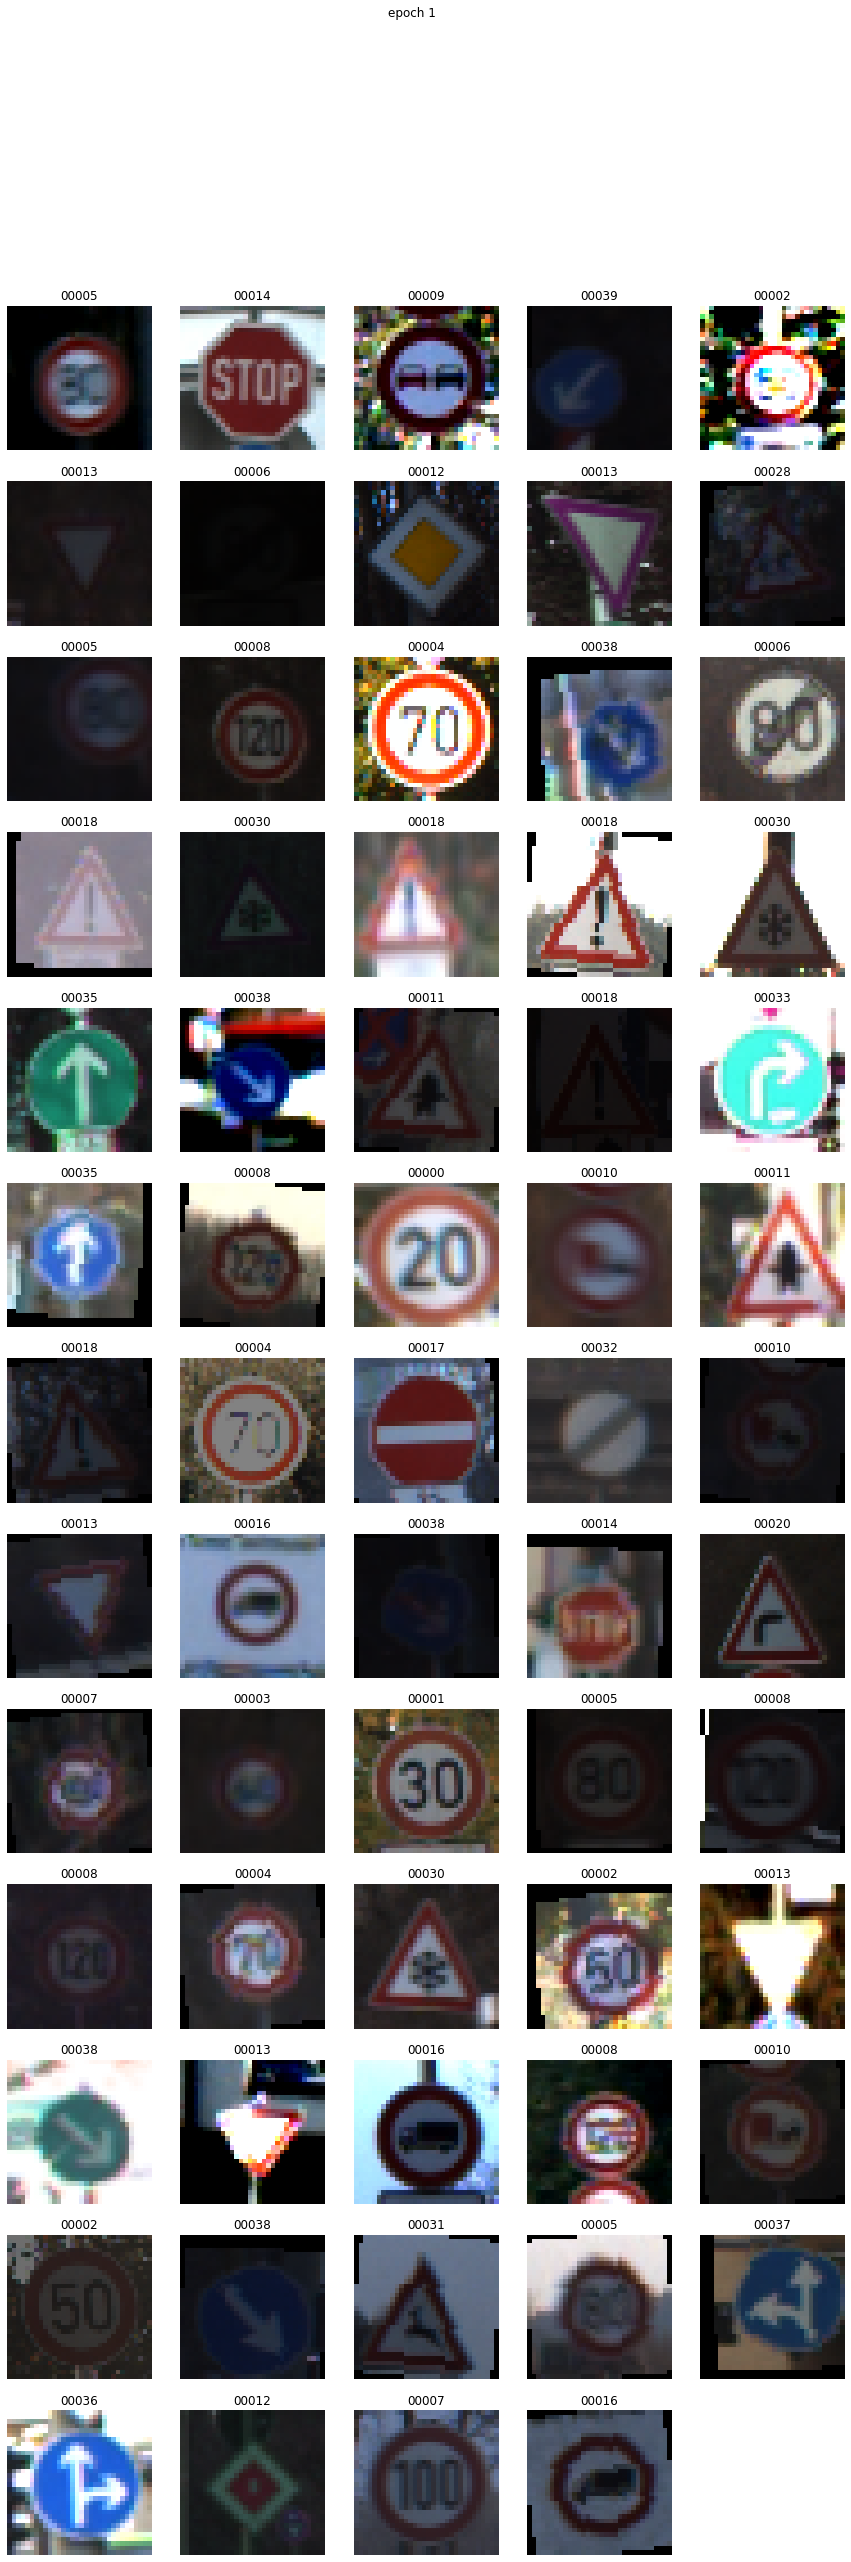

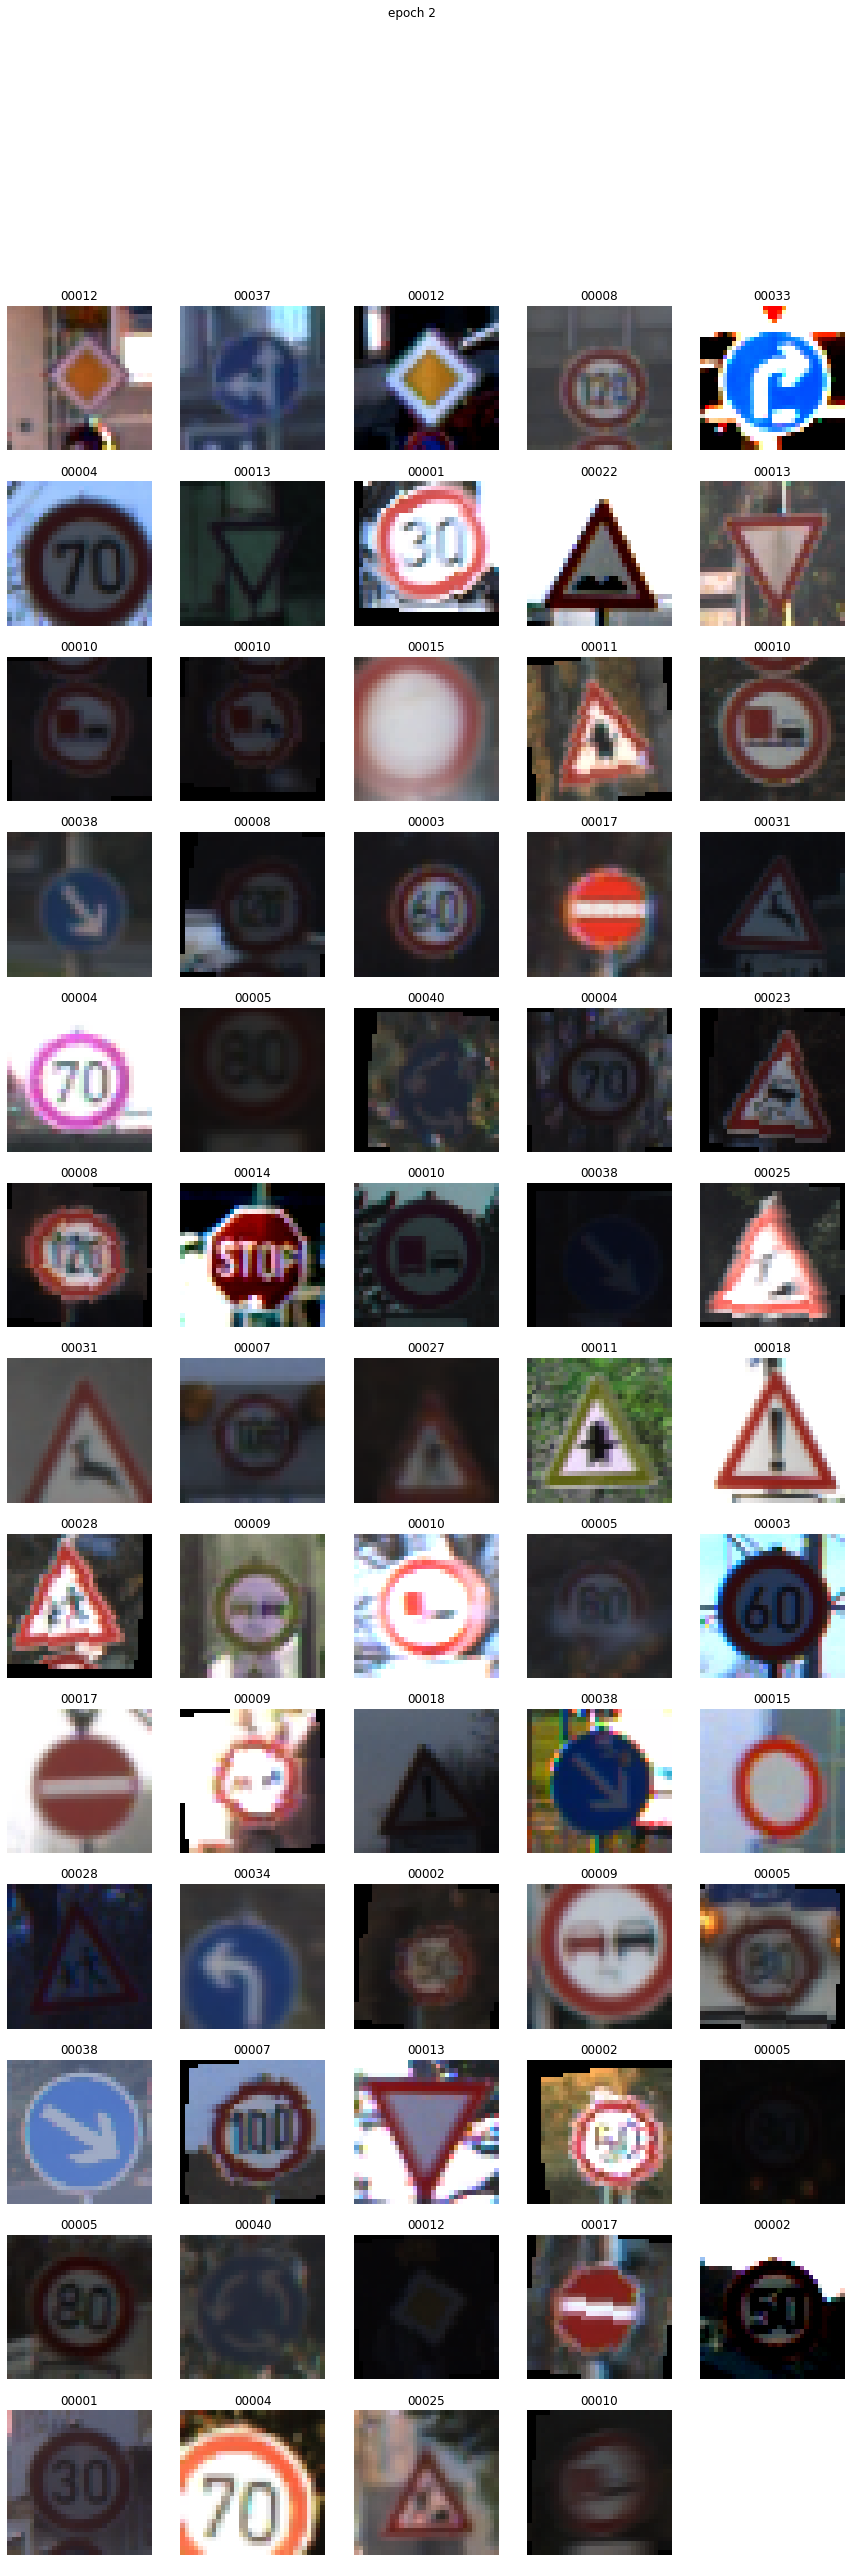

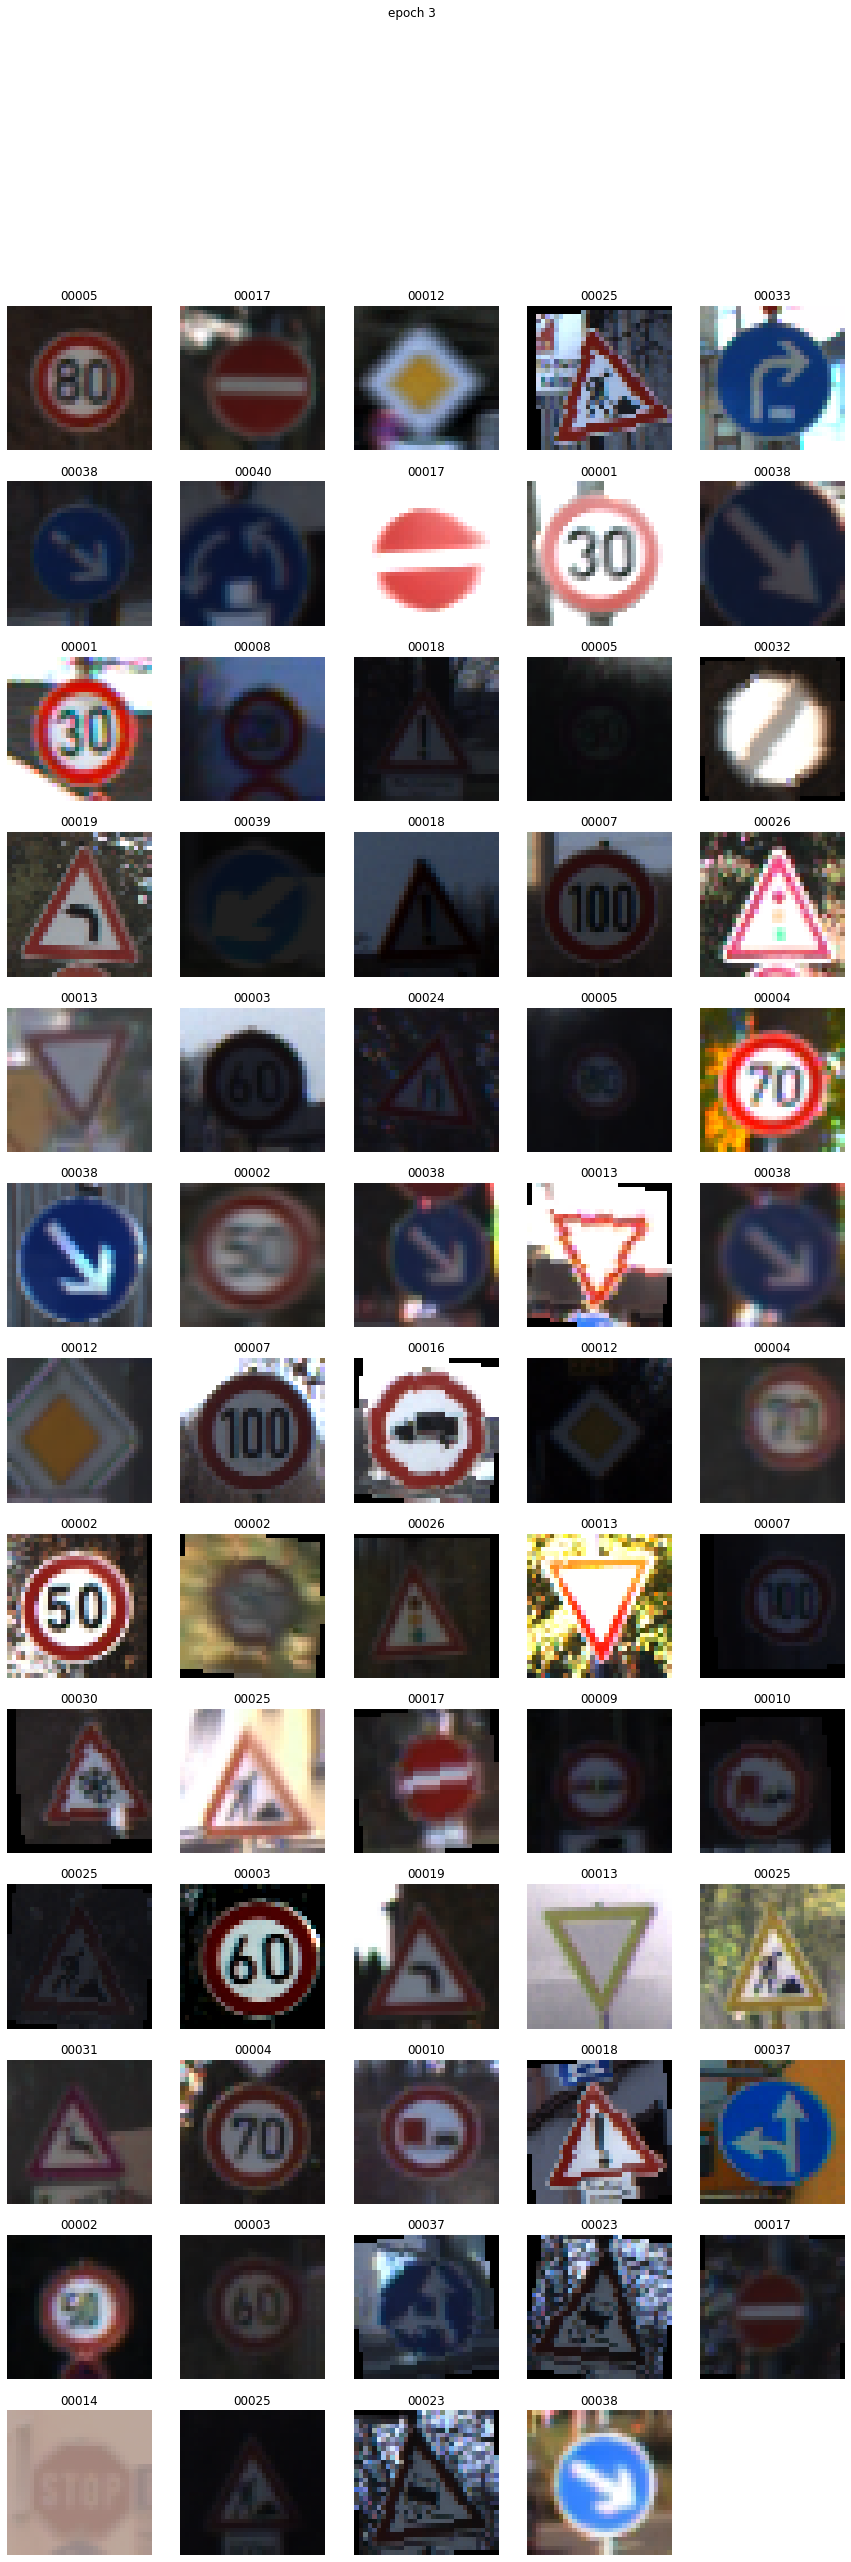

In [19]:
#ver os batchs
image_batch, label_batch = next(iter(train_dataset))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 3)

#### Validation Dataset

In [20]:
train_size = int(0.8*train_dataset_length)
val_size = int(0.2*train_dataset_length)

In [21]:
train_Data = train_dataset.take(train_size)
val_Data = train_dataset.skip(train_size)
print(tf.data.experimental.cardinality(train_Data).numpy())

251008


#### Modelo

In [22]:
modelV3 = Sequential()

modelV3.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
modelV3.add(LeakyReLU(alpha=0.01))  
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Conv2D(196, (5, 5) )) 
modelV3.add(LeakyReLU(alpha=0.01))
modelV3.add(MaxPooling2D(pool_size=(2, 2)))
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Conv2D(256, (5, 5) ) )   
modelV3.add(LeakyReLU(alpha=0.01))
modelV3.add(MaxPooling2D(pool_size=(2, 2)))
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Flatten())
modelV3.add(LeakyReLU(alpha=0.0)) 
modelV3.add(Dense(384))
modelV3.add(LeakyReLU(alpha=0.0))             
modelV3.add(Dropout(0.5)) 

modelV3.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

modelV3.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])

In [23]:
file_pathV3 = './TrainModels/Massive_Augmentation.ckpt'

callbacksV3 = prepare_callbacks(file_pathV3)

historyV3 = modelV3.fit(train_Data, steps_per_epoch = train_size/BATCH_SIZE,
          epochs=50, 
          validation_data = val_Data,
          validation_steps=val_size/BATCH_SIZE, 
          callbacks = callbacksV3)

# historyV3 = modelV3.fit(dataV3,
#           epochs=50, 
#           validation_data = val_Data, 
#           callbacks = callbacksV3)      

Epoch 1/50


2022-06-01 15:34:37.761437: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-01 15:34:38.013622: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3922/3922 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.7416
Epoch 1: val_accuracy improved from -inf to 0.96695, saving model to ./TrainModels/Massive_Augmentation.ckpt
3922/3922 [==============================] - 186s 47ms/step - loss: 0.9337 - accuracy: 0.7416 - val_loss: 0.1250 - val_accuracy: 0.9670 - lr: 1.0000e-04
Epoch 2/50
3922/3922 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9462
Epoch 2: val_accuracy improved from 0.96695 to 0.98807, saving model to ./TrainModels/Massive_Augmentation.ckpt
3922/3922 [==============================] - 188s 48ms/step - loss: 0.1837 - accuracy: 0.9462 - val_loss: 0.0476 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 3/50
3921/3922 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9697
Epoch 3: val_accuracy improved from 0.98807 to 0.99204, saving model to ./TrainModels/Massive_Augmentation.ckpt
3922/3922 [==============================] - 182s 46ms/step - loss: 0.1030 - a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


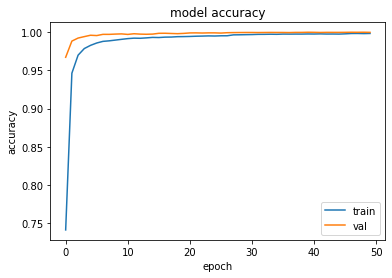

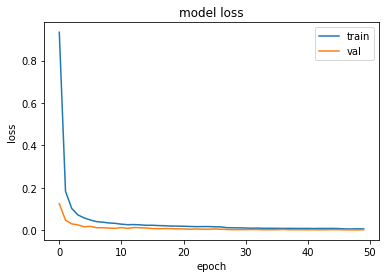

198/198 - 2s - loss: 0.0236 - accuracy: 0.9937 - 2s/epoch - 12ms/step
1/1 - 40s - loss: 2.0489e-08 - accuracy: 1.0000 - 40s/epoch - 40s/step


In [25]:
show_history(historyV3)

modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(test_Data, verbose=2)
valV3 = modelV3.evaluate(val_Data, steps=1, batch_size=val_size, verbose=2)

In [26]:
model_eval = modelV3.evaluate(test_Data, verbose=2)
print(model_eval)

model_val = modelV3.evaluate(val_Data, steps=1, batch_size=val_size, verbose=2)
print(model_val)

198/198 - 2s - loss: 0.0236 - accuracy: 0.9937 - 2s/epoch - 12ms/step
[0.023584414273500443, 0.993665874004364]
1/1 - 41s - loss: 1.3975e-05 - accuracy: 1.0000 - 41s/epoch - 41s/step
[1.3974578905617818e-05, 1.0]


In [27]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in test_Data.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV3.predict(images.numpy()))

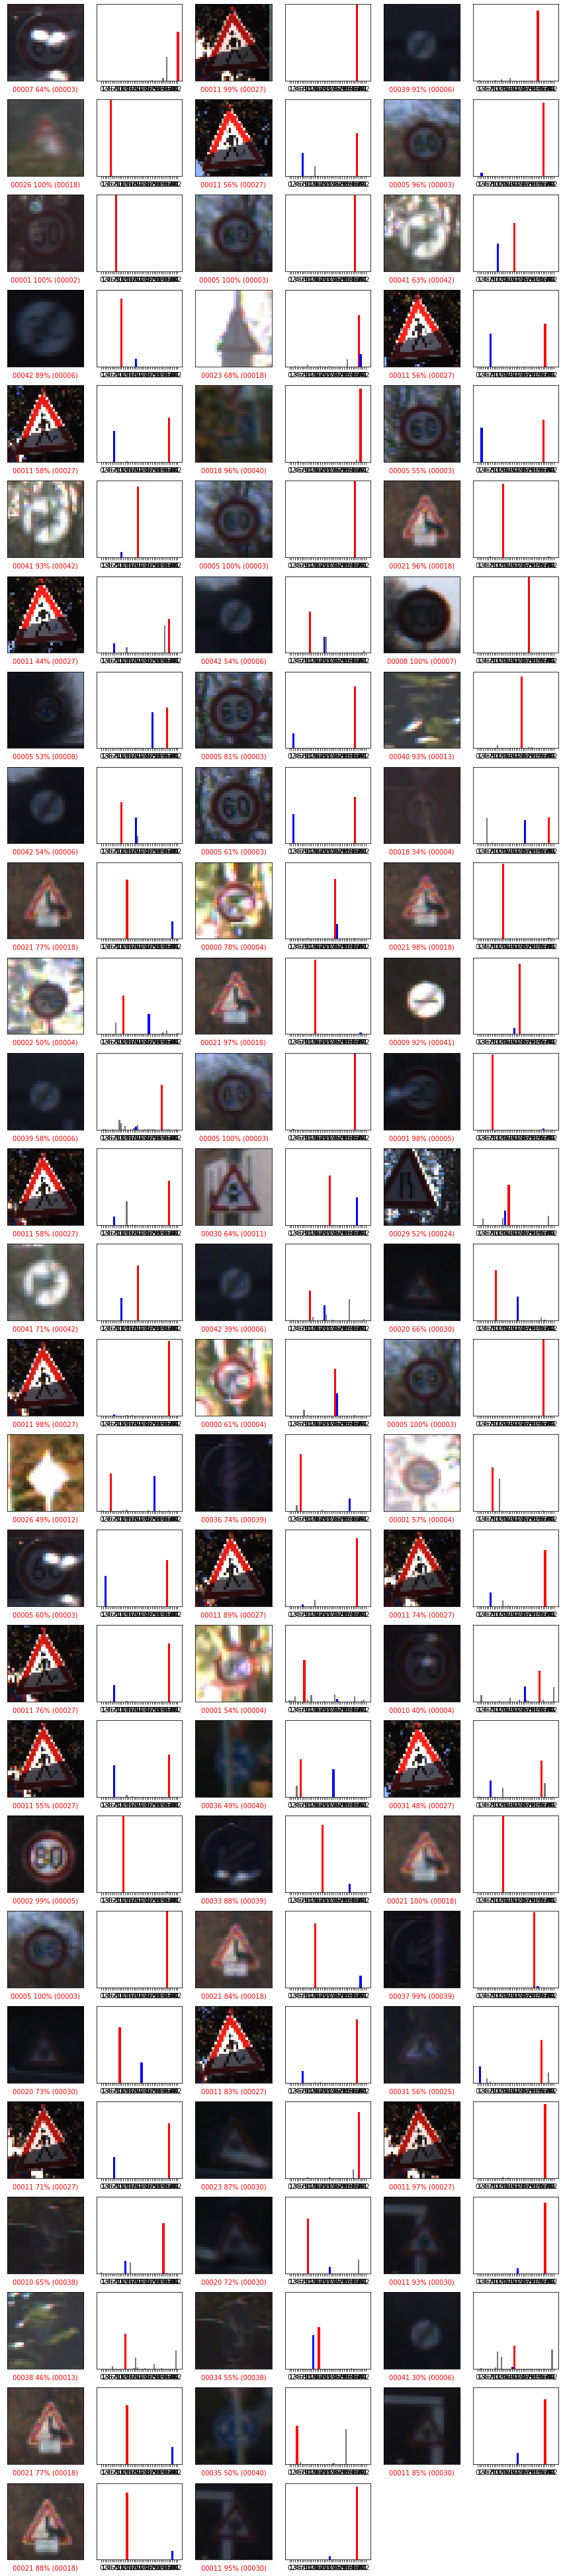

In [31]:
show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9937 )/3 + 1))

In [ ]:
all_labels = [np.argmax(x) for x in numpy_labels]
all_preds = [np.argmax(x) for x in pred]
    
conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

show_confusion_matrix(conf_mat.numpy(), 8)